# NEB using ASE

### 1. Setting up an EAM calculator.

Suppose we want to calculate the minimum energy path of adatom diffusion on a (100) surface. We first need to choose an energy model, and in ASE, this is done by defining a "calculator". Let's choose our calculator to be Zhou's aluminum EAM potential, which we've used in previous labs.

We first import ASE's built-in EAM calculator class:

In [1]:
from ase.calculators.eam import EAM

Then set the potential file:

In [2]:
import os
pot_file = os.environ.get('LAMMPS_POTENTIALS') + '/Al_zhou.eam.alloy'

In [3]:
print(pot_file)

/home/bond/Software/lammps-12Dec18/potentials/Al_zhou.eam.alloy


We just have to point ASE to the potential file. It automatically parses the file and constructs the corresponding EAM calculator for us:

In [4]:
zhou = EAM(potential=pot_file)

Next, we define our surface. Let's put the atom in the "hollow" site on the (100) surface. You can find out the adatom sites that are available for different types of surfaces in the ASE documentation: https://wiki.fysik.dtu.dk/ase/ase/build/surface.html

In [5]:
from ase.build import fcc100, add_adsorbate
slab = fcc100('Al', size=(3, 3, 3))
add_adsorbate(slab, 'Al', 2, 'hollow')  # put adatom 2 A above the slab
slab.center(vacuum=5.0, axis=2)  # 5 A of vacuum on either side

Let's see what the slab looks like:

In [6]:
from ase.visualize import view
view(slab, viewer='x3d')

Let's set the calculator of the slab to the EAM calculator we defined above:

In [7]:
slab.set_calculator(zhou)

This lets us calculate the potential energy and forces on the atoms:

In [8]:
slab.get_potential_energy()  # energy in eV

-91.4995116497028

In [9]:
slab.get_forces()  # forces in eV/A

array([[-3.18318611e-03, -3.18318611e-03,  9.21305488e-02],
       [ 3.18318611e-03, -3.18318611e-03,  9.21305488e-02],
       [ 5.93442496e-16, -1.19866402e-03,  9.97126824e-02],
       [-3.18318611e-03,  3.18318611e-03,  9.21305488e-02],
       [ 3.18318611e-03,  3.18318611e-03,  9.21305488e-02],
       [ 5.52848819e-16,  1.19866402e-03,  9.97126824e-02],
       [-1.19866402e-03,  5.07137923e-16,  9.97126824e-02],
       [ 1.19866402e-03,  4.93860885e-16,  9.97126824e-02],
       [ 4.86239445e-16,  4.44806064e-16,  1.05896212e-01],
       [-1.84538076e-16, -8.61500270e-17,  3.39521281e-02],
       [-2.05834568e-02, -4.81835251e-17,  1.62041430e-02],
       [ 2.05834568e-02, -9.02056208e-17,  1.62041430e-02],
       [-1.59205828e-16, -2.05834568e-02,  1.62041430e-02],
       [ 1.58242313e-02,  1.58242313e-02, -2.96386893e-02],
       [-1.58242313e-02,  1.58242313e-02, -2.96386893e-02],
       [-1.24900090e-16,  2.05834568e-02,  1.62041430e-02],
       [ 1.58242313e-02, -1.58242313e-02

Notice the nonzero forces, and in particular the strong force in the z-direction acting on the adatom. That's a signal that we're not relaxed.

### 2. Structure relaxation in ASE.

We can use one of ASE's built-in structure optimizers to relax the structure and find the local energy minimum predicted by the EAM potential. The optimization terminates when the maximum force on an atom falls below fmax, which we set to 0.1 meV/A.

In [10]:
from ase.optimize import BFGS
dyn = BFGS(slab)
dyn.run(fmax=0.0001)

      Step     Time          Energy         fmax
BFGS:    0 13:53:53      -91.499512        1.0911
BFGS:    1 13:53:53      -91.518468        1.0423
BFGS:    2 13:53:53      -91.562652        0.9126
BFGS:    3 13:53:54      -91.600450        0.7777
BFGS:    4 13:53:54      -91.631913        0.6393
BFGS:    5 13:53:54      -91.657246        0.4993
BFGS:    6 13:53:55      -91.676842        0.3598
BFGS:    7 13:53:55      -91.691349        0.2234
BFGS:    8 13:53:55      -91.701789        0.2234
BFGS:    9 13:53:55      -91.709734        0.2489
BFGS:   10 13:53:56      -91.717299        0.2561
BFGS:   11 13:53:56      -91.726306        0.2358
BFGS:   12 13:53:56      -91.737340        0.1832
BFGS:   13 13:53:56      -91.746419        0.1127
BFGS:   14 13:53:57      -91.749121        0.0900
BFGS:   15 13:53:57      -91.750565        0.0813
BFGS:   16 13:53:57      -91.751209        0.0726
BFGS:   17 13:53:57      -91.752397        0.0688
BFGS:   18 13:53:58      -91.753847        0.0675
B

True

To compute the activation barrier for adatom diffusion, we first need to know the endpoint of the transition path, which we can determine by looking at the atomic coordinates.

In [11]:
slab_2 = fcc100('Al', size=(3, 3, 3))
add_adsorbate(slab_2, 'Al', 2, 'hollow')  # put adatom 2 A above the slab
slab_2.center(vacuum=5.0, axis=2)  # 5 A of vacuum on either side
slab_2.set_calculator(EAM(potential=pot_file))

slab_2.positions

array([[ 0.        ,  0.        ,  5.        ],
       [ 2.86378246,  0.        ,  5.        ],
       [ 5.72756493,  0.        ,  5.        ],
       [ 0.        ,  2.86378246,  5.        ],
       [ 2.86378246,  2.86378246,  5.        ],
       [ 5.72756493,  2.86378246,  5.        ],
       [ 0.        ,  5.72756493,  5.        ],
       [ 2.86378246,  5.72756493,  5.        ],
       [ 5.72756493,  5.72756493,  5.        ],
       [ 1.43189123,  1.43189123,  7.025     ],
       [ 4.2956737 ,  1.43189123,  7.025     ],
       [ 7.15945616,  1.43189123,  7.025     ],
       [ 1.43189123,  4.2956737 ,  7.025     ],
       [ 4.2956737 ,  4.2956737 ,  7.025     ],
       [ 7.15945616,  4.2956737 ,  7.025     ],
       [ 1.43189123,  7.15945616,  7.025     ],
       [ 4.2956737 ,  7.15945616,  7.025     ],
       [ 7.15945616,  7.15945616,  7.025     ],
       [ 0.        ,  0.        ,  9.05      ],
       [ 2.86378246,  0.        ,  9.05      ],
       [ 5.72756493,  0.        ,  9.05 

In [43]:
slab_2.positions[-1][0:2] = slab_2.positions[10][0:2]  # notice the adatom is directly above atom 9
view(slab_2, viewer='x3d')

We again relax the structure:

In [44]:
dyn = BFGS(slab_2)
dyn.run(fmax=0.0001)

      Step     Time          Energy         fmax
BFGS:    0 23:00:59      -91.499512        1.0911
BFGS:    1 23:00:59      -91.518468        1.0423
BFGS:    2 23:00:59      -91.562652        0.9126
BFGS:    3 23:00:59      -91.600450        0.7777
BFGS:    4 23:01:00      -91.631913        0.6393
BFGS:    5 23:01:00      -91.657246        0.4993
BFGS:    6 23:01:00      -91.676842        0.3598
BFGS:    7 23:01:00      -91.691349        0.2234
BFGS:    8 23:01:00      -91.701789        0.2234
BFGS:    9 23:01:00      -91.709734        0.2489
BFGS:   10 23:01:00      -91.717299        0.2561
BFGS:   11 23:01:01      -91.726306        0.2358
BFGS:   12 23:01:01      -91.737340        0.1832
BFGS:   13 23:01:01      -91.746419        0.1127
BFGS:   14 23:01:01      -91.749121        0.0900
BFGS:   15 23:01:01      -91.750565        0.0813
BFGS:   16 23:01:01      -91.751209        0.0726
BFGS:   17 23:01:02      -91.752397        0.0688
BFGS:   18 23:01:02      -91.753847        0.0675
B

True

### Nudged elastic band calculations.

We've succeeded in relaxing the endpoints. We can proceed to search for the saddle point using NEB.

In [47]:
from ase.neb import NEB
import numpy as np

In [48]:
# make band
no_images = 15
images = [slab]
images += [slab.copy() for i in range(no_images-2)]
images += [slab_2]
neb = NEB(images)

# interpolate middle images
neb.interpolate()

# set calculators of middle images
pot_dir = os.environ.get('LAMMPS_POTENTIALS')
for image in images[1:no_images-1]:
    image.set_calculator(EAM(potential=pot_file))

# optimize the NEB trajectory
optimizer = BFGS(neb)
optimizer.run(fmax=0.01)

# calculate the potential energy of each image
pes = np.zeros(no_images)
pos = np.zeros((no_images, len(images[0]), 3))
for n, image in enumerate(images):
    pes[n] = image.get_potential_energy()
    pos[n] = image.positions

      Step     Time          Energy         fmax
BFGS:    0 23:04:19      -90.892991        2.2800
BFGS:    1 23:04:21      -91.042482        1.7763
BFGS:    2 23:04:23      -91.177466        1.2329
BFGS:    3 23:04:25      -91.266516        0.7628
BFGS:    4 23:04:27      -91.316924        0.3577
BFGS:    5 23:04:30      -91.335721        0.2236
BFGS:    6 23:04:33      -91.337170        0.2026
BFGS:    7 23:04:34      -91.339221        0.2315
BFGS:    8 23:04:36      -91.346774        0.2554
BFGS:    9 23:04:38      -91.355850        0.1980
BFGS:   10 23:04:40      -91.359967        0.1192
BFGS:   11 23:04:42      -91.360330        0.0942
BFGS:   12 23:04:43      -91.361065        0.1130
BFGS:   13 23:04:45      -91.363197        0.1029
BFGS:   14 23:04:47      -91.365631        0.0881
BFGS:   15 23:04:49      -91.366350        0.0860
BFGS:   16 23:04:51      -91.366333        0.0632
BFGS:   17 23:04:53      -91.366578        0.0773
BFGS:   18 23:04:55      -91.367322        0.0725
B

Let's plot the results.

In [51]:
import matplotlib.pyplot as plt

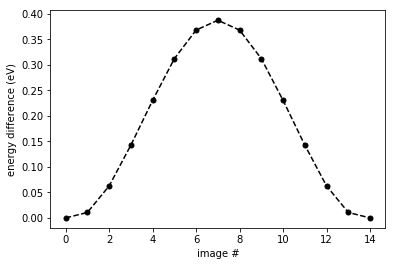

In [56]:
plt.plot(pes-pes[0], 'k.', markersize=10)  # plot energy difference in eV w.r.t. first image
plt.plot(pes-pes[0], 'k--', markersize=10)
plt.xlabel('image #')
plt.ylabel('energy difference (eV)')
plt.show()

# FLARE code

### 1. Setup

In this lab, we'll use the Bayesian ML code FLARE ("fast learning of atomistic rare events") that has [recently been made open source](https://arxiv.org/abs/1904.02042). To set it up on Google cloud, vbox, or your personal machine, you'll need to pull it from github. I'll give the commands for setting everything up on an AP275 Google cloud instance, but the steps will be pretty much the same on any machine.

__git clone https://github.com/mir-group/flare.git__

The code is written in Python, but inner loops are accelerated with Numba, which you'll need to install with pip.

__sudo apt install python3-pip__

__pip3 install numba__

You'll see warnings from Numba that a more recent version of "colorama" needs to be installed. You can install it with pip:

__pip3 install colorama__

You may find it helpful to add the FLARE directory to your Python path and bash environment, which makes it easier to directly import files.

__nano .profile__

__export FLARE=\\$HOME/Software/flare__

__export PYTHONPATH=\\$PYTHONPATH:\\$FLARE:\\$FLARE/otf_engine:\\$FLARE/modules__

__source .profile__

### 2. A toy example

Let's look at a simple example to get a feel for how the code works. Let's put two atoms in a box along the x axis:

In [1]:
import numpy as np
from ase import Atoms

In [2]:
positions = np.array([[0, 0, 0], [1, 0, 0]])
cell = np.eye(3) * 10

two_atoms = Atoms(positions=positions, cell=cell)

In [3]:
from ase.visualize import view
view(two_atoms, viewer='x3d')

Let's put equal and opposite forces on our atoms.

In [4]:
forces = np.array([[-1, 0, 0], [1, 0, 0]])

The FLARE code uses Gaussian process regression (GPR) to construct a covariant force field based on atomic forces, which are the training labels. GPR is a kernel based machine learning method, which means that it makes predictions by comparing test points to structures in the training set. For this simple system, we choose a two-body kernel, which compares pairwise distances in two structures.

In [5]:
from kernels import two_body, two_body_grad, two_body_force_en
from gp import GaussianProcess

The GP models are local, and require you to choose a cutoff. We'll pick 4 A. The kernel has a few hyperparameters which control uncertainty estimates and length scales. They can be optimized in a rigorous way by maximizing the likelihood of the training data, but for this lab we'll just set the hyperparameters to reasonable values.

In [6]:
hyps = np.array([1, 1, 1e-3])  # signal std, length scale, noise std
cutoffs = np.array([2])

gp_model = GaussianProcess(kernel=two_body, kernel_grad=two_body_grad, hyps=hyps,
                           cutoffs=cutoffs, energy_force_kernel=two_body_force_en)

The GP models take structure objects as input, which contain information about the cell and atomic coordinates (much like the Atoms class in ASE).

In [7]:
import struc

In [8]:
training_struc = struc.Structure(cell=cell, species=['A']*2, positions=positions)

We train the GP model by giving it training structures and corresponding forces:

In [9]:
gp_model.update_db(training_struc, forces)
gp_model.set_L_alpha()

As a quick check, let's make sure we get reasonable results on the training structure:

In [10]:
gp_model.predict(gp_model.training_data[0], 2)  # second argument is the force component (x=1, y=2, z=3)

(0.0, 0.0)

To make it easier to get force and energy estimates from the GP model, we can wrap it in an ASE calculator:

In [11]:
from gp_calculator import GPCalculator

In [12]:
gp_calc = GPCalculator(gp_model)

Now let's test the covariance property of the model. Let's rotate the structure by 90 degrees, and see what forces we get.

In [13]:
# print positions, energy, and forces before rotation
two_atoms.set_calculator(gp_calc)
print(two_atoms.positions)
print(two_atoms.get_potential_energy())
print(two_atoms.get_forces())

[[0. 0. 0.]
 [1. 0. 0.]]
0.39999995997641236
[[-0.9999999  0.         0.       ]
 [ 0.9999999  0.         0.       ]]


In [15]:
two_atoms.rotate(90, 'z')  # rotate the atoms 90 degrees about the z axis
two_atoms.set_calculator(gp_calc)  # set calculator to gp model

In [16]:
# print positions, energy, and forces after rotation
print(two_atoms.positions)
print(two_atoms.get_potential_energy())
print(two_atoms.get_forces())

[[0.000000e+00 0.000000e+00 0.000000e+00]
 [6.123234e-17 1.000000e+00 0.000000e+00]]
0.39999995997641236
[[-6.12323338e-17 -9.99999900e-01  0.00000000e+00]
 [ 6.12323338e-17  9.99999900e-01  0.00000000e+00]]


### 3. Two plus three body model

In the lab, we'll add a three-body term to the potential, which makes the model significantly more accurate for certain systems. Let's see how this would work for our (100) slab.

In [1]:
# initialize gp model
import kernels
import gp
import numpy as np

kernel = kernels.two_plus_three_body
kernel_grad = kernels.two_plus_three_body_grad
hyps = np.array([1, 1, 0.1, 1, 1e-3]) # sig2, ls2, sig3, ls3, noise std
cutoffs = np.array([4.96, 4.96])
energy_force_kernel = kernels.two_plus_three_force_en

gp_model = gp.GaussianProcess(kernel, kernel_grad, hyps, cutoffs,
                              energy_force_kernel=energy_force_kernel)

In [2]:
# make slab structure in ASE
from ase.build import fcc100, add_adsorbate
import os
from ase.calculators.eam import EAM

slab = fcc100('Al', size=(3, 3, 3))
add_adsorbate(slab, 'Al', 2, 'hollow')  # put adatom 2 A above the slab
slab.center(vacuum=5.0, axis=2)  # 5 A of vacuum on either side
pot_file = os.environ.get('LAMMPS_POTENTIALS') + '/Al_zhou.eam.alloy'
zhou = EAM(potential=pot_file)
slab.set_calculator(zhou)

In [3]:
# make training structure
import struc

training_struc = struc.Structure(cell=slab.cell, 
                                 species=['Al']*len(slab),
                                 positions=slab.positions)
training_forces = slab.get_forces()

In [4]:
# add atoms to training database
gp_model.update_db(training_struc, training_forces)
gp_model.set_L_alpha()

In [5]:
# wrap in ASE calculator
from gp_calculator import GPCalculator

gp_calc = GPCalculator(gp_model)

In [6]:
# test on training structure
slab.set_calculator(gp_calc)
GP_forces = slab.get_forces()

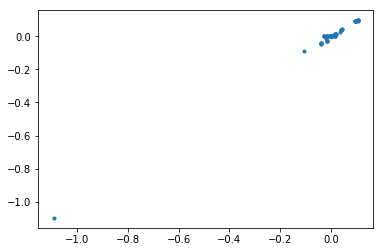

In [8]:
# check accuracy by making a parity plot
import matplotlib.pyplot as plt

plt.plot(training_forces.reshape(-1), GP_forces.reshape(-1), '.')
plt.show()